## Load configurations

In [1]:
from cfgs.content_classification_v2 import get_cfg

cfgs = get_cfg()
print('\n', cfgs, '\n')


 CLASSES: [{'Genre': {0: 'Comedy', 1: 'Action', 2: 'Documentary', 3: 'Crime', 4: 'Animation', 5: 'Horror'}, 'Rating': {0: 'value'}, 'Year': {0: 'value'}}]
HYPERPARAMS:
  BATCH_SIZE_TEST: 64
  BATCH_SIZE_TR: 64
  BATCH_SIZE_VAL: 64
  EPOCHS: 30
  LR: 0.0001
  TEST_SPLIT: 0.9
  VAL_SPLIT: 0.9
IMAGE:
  RESOLUTION: (150, 200, 3)
MODEL:
  BACKBONE: InceptionV3
  STRUCTURE: [{0: {'type': 'Genre', 'outNeurons': 6, 'outActivation': 'sigmoid', 'loss': 'categorical_crossentropy', 'weight': 1, 'metric': 'accuracy'}, 1: {'type': 'Rating', 'outNeurons': 1, 'outActivation': 'linear', 'loss': 'mse', 'weight': 1, 'metric': 'mae'}, 2: {'type': 'Year', 'outNeurons': 1, 'outActivation': 'linear', 'loss': 'mse', 'weight': 1, 'metric': 'mae'}}] 



In [2]:
dataset_dict = cfgs.CLASSES[0]
dataset_dict['Genre_alias'] = dict((g, i) for i, g in dataset_dict['Genre'].items())

## Load data and initialize generator

In [3]:
import pandas as pd
from data_processing.data_generator import DataGenerator
from sklearn.preprocessing import StandardScaler

In [4]:
df = pd.read_pickle("/home/robotics/content-classification/data_processing/balanced_data.pkl")

In [5]:
data_generator = DataGenerator(df, dataset_dict, cfgs.HYPERPARAMS.TEST_SPLIT, cfgs.HYPERPARAMS.VAL_SPLIT, cfgs.IMAGE.RESOLUTION)
data_generator.df.head()

Index                       Name  Year  Genre  Rating  \
0  tt0077838             The Last Waltz  1978      2     8.2   
1  tt0218080                  Agent Red  2000      1     3.5   
2  tt0378889  Tom, Tom, the Piper's Son  1969      0     6.2   
3  tt1183696                Second Skin  2009      2     6.6   
4  tt0068549                     Essene  1972      2     7.1   

                                         Poster_path  
0  /home/robotics/Documents/data/Posters/1978/tt0...  
1  /home/robotics/Documents/data/Posters/2000/tt0...  
2  /home/robotics/Documents/data/Posters/1969/tt0...  
3  /home/robotics/Documents/data/Posters/2009/tt1...  
4  /home/robotics/Documents/data/Posters/1972/tt0...

In [6]:
train_idx, valid_idx, test_idx = data_generator.split_dataset() 

## Build and compile model

In [7]:
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from model.architecture import MultiOutputModel

In [8]:
structure = cfgs.MODEL.STRUCTURE[0]
content_model = MultiOutputModel(*cfgs.IMAGE.RESOLUTION, structure)
content_model.build_model("InceptionV3")
keras.utils.plot_model(content_model.model, show_shapes=True)

In [9]:
# opt = SGD()
opt = Adam(lr=cfgs.HYPERPARAMS.LR, decay=cfgs.HYPERPARAMS.LR/cfgs.HYPERPARAMS.EPOCHS)
content_model.compile_model(opt)
content_model.model.summary()

Model: "content_classification"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 99, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 99, 32)   0           batch_normalization[0][0]        
_____________________________________________________________________________

## Train Model

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.backend import clear_session
import tensorflow as tf

In [11]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

# GPU check - CUDA 11.1 with cuDNN 8.05 on 460.39 - GTX 1060 6GB
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))

clear_session()

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [12]:
tr_generator = data_generator.generate_images(train_idx, cfgs.HYPERPARAMS.BATCH_SIZE_TR, True)
val_generator = data_generator.generate_images(valid_idx, cfgs.HYPERPARAMS.BATCH_SIZE_VAL, True)

In [13]:
import datetime

%load_ext tensorboard
log_dir = log_dir = "./logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

callbacks = [keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)]
# keras.callbacks.ModelCheckpoint('./checkpoints', monitor='val_loss', verbose=0, 
#                                              save_best_only=False, save_weights_only=False, 
#                                              mode='auto', save_freq='epoch')

In [14]:
%%time
history = content_model.model.fit(tr_generator, 
                    steps_per_epoch=len(train_idx)//cfgs.HYPERPARAMS.BATCH_SIZE_TR,
                    epochs=cfgs.HYPERPARAMS.EPOCHS,
                    callbacks=callbacks,
                    validation_data=val_generator,
                    validation_steps=len(valid_idx)//cfgs.HYPERPARAMS.BATCH_SIZE_VAL)

Epoch 1/30
126/151 [========================>.....] - ETA: 3s - loss: 11.9191 - Genre_loss: 2.8610 - Rating_loss: 4.1616 - Year_loss: 4.8966 - Genre_accuracy: 0.1792 - Rating_mae: 1.6071 - Year_mae: 1.7484
* * * * * Image could not be loaded - skipping * * * * *
151/151 [==============================] - 29s 148ms/step - loss: 11.7802 - Genre_loss: 2.8458 - Rating_loss: 4.0894 - Year_loss: 4.8451 - Genre_accuracy: 0.1804 - Rating_mae: 1.5912 - Year_mae: 1.7380 - val_loss: 3.5469 - val_Genre_loss: 1.7516 - val_Rating_loss: 0.8759 - val_Year_loss: 0.9194 - val_Genre_accuracy: 0.2861 - val_Rating_mae: 0.8235 - val_Year_mae: 0.9069
Epoch 2/30
127/151 [========================>.....] - ETA: 3s - loss: 8.8550 - Genre_loss: 2.6069 - Rating_loss: 2.8316 - Year_loss: 3.4164 - Genre_accuracy: 0.2071 - Rating_mae: 1.3197 - Year_mae: 1.4476
* * * * * Image could not be loaded - skipping * * * * *
151/151 [==============================] - 21s 140ms/step - loss: 8.8025 - Genre_loss: 2.6000 - Rating

Epoch 14/30
138/151 [==========================>...] - ETA: 1s - loss: 2.9234 - Genre_loss: 1.7177 - Rating_loss: 0.5120 - Year_loss: 0.6936 - Genre_accuracy: 0.3586 - Rating_mae: 0.5612 - Year_mae: 0.6503
* * * * * Image could not be loaded - skipping * * * * *
151/151 [==============================] - 21s 140ms/step - loss: 2.9183 - Genre_loss: 1.7149 - Rating_loss: 0.5109 - Year_loss: 0.6925 - Genre_accuracy: 0.3593 - Rating_mae: 0.5605 - Year_mae: 0.6498 - val_loss: 1.4888 - val_Genre_loss: 1.4114 - val_Rating_loss: 0.0482 - val_Year_loss: 0.0292 - val_Genre_accuracy: 0.4551 - val_Rating_mae: 0.1827 - val_Year_mae: 0.1421
Epoch 15/30
138/151 [==========================>...] - ETA: 1s - loss: 2.7295 - Genre_loss: 1.6662 - Rating_loss: 0.4410 - Year_loss: 0.6223 - Genre_accuracy: 0.3645 - Rating_mae: 0.5186 - Year_mae: 0.6197
* * * * * Image could not be loaded - skipping * * * * *
151/151 [==============================] - 21s 139ms/step - loss: 2.7248 - Genre_loss: 1.6646 - Rating

Epoch 27/30
149/151 [============================>.] - ETA: 0s - loss: 1.5997 - Genre_loss: 1.3298 - Rating_loss: 0.1010 - Year_loss: 0.1690 - Genre_accuracy: 0.4868 - Rating_mae: 0.2516 - Year_mae: 0.3265
* * * * * Image could not be loaded - skipping * * * * *
151/151 [==============================] - 21s 140ms/step - loss: 1.5995 - Genre_loss: 1.3297 - Rating_loss: 0.1009 - Year_loss: 0.1689 - Genre_accuracy: 0.4869 - Rating_mae: 0.2516 - Year_mae: 0.3263 - val_loss: 1.4179 - val_Genre_loss: 1.3735 - val_Rating_loss: 0.0283 - val_Year_loss: 0.0161 - val_Genre_accuracy: 0.4883 - val_Rating_mae: 0.1428 - val_Year_mae: 0.1146
Epoch 28/30
150/151 [============================>.] - ETA: 0s - loss: 1.5413 - Genre_loss: 1.3019 - Rating_loss: 0.0909 - Year_loss: 0.1484 - Genre_accuracy: 0.4963 - Rating_mae: 0.2382 - Year_mae: 0.3007
* * * * * Image could not be loaded - skipping * * * * *
151/151 [==============================] - 22s 148ms/step - loss: 1.5413 - Genre_loss: 1.3020 - Rating

In [15]:
content_model.model.save("Model_sigmoid")

INFO:tensorflow:Assets written to: Model_sigmoid/assets


## TensorBoard and plots

In [ ]:
# %tensorboard --logdir logs

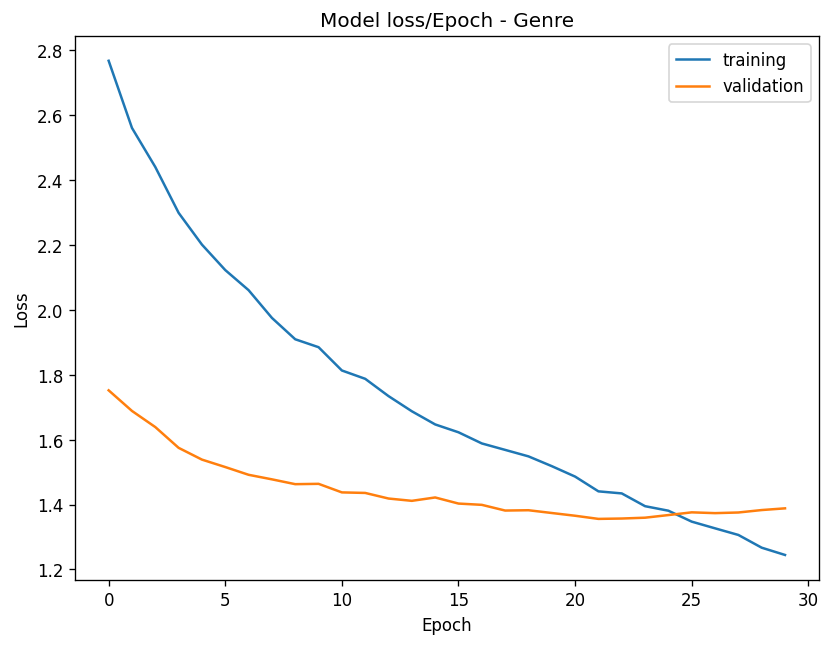

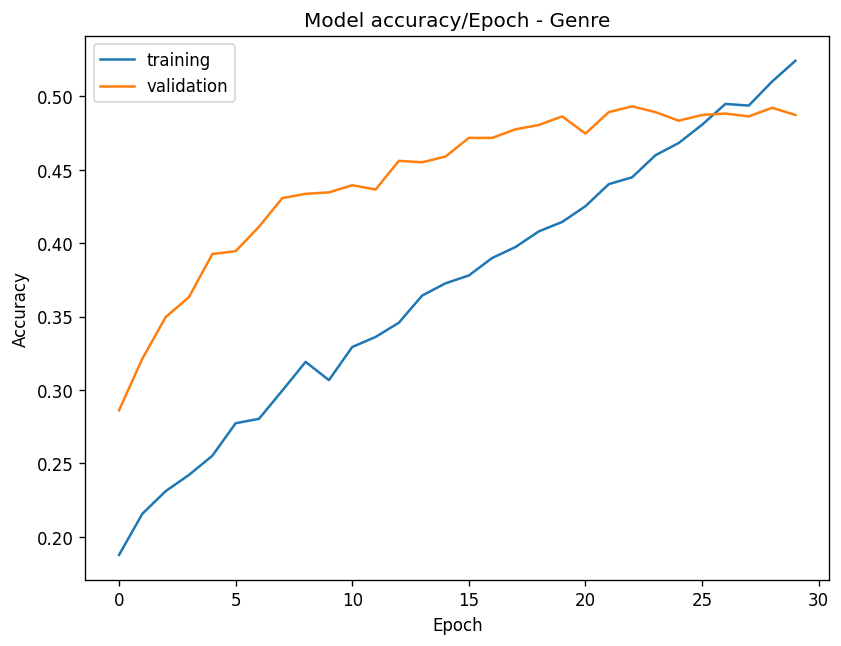

Model train loss: 1.245
Model train accuracy: 0.5242


In [16]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 6), dpi=120)
plt.plot(history.history['Genre_loss'])
plt.plot(history.history['val_Genre_loss'])
plt.title('Model loss/Epoch - Genre')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'])
plt.show()

plt.figure(figsize=(8, 6), dpi=120)
plt.plot(history.history['Genre_accuracy'])
plt.plot(history.history['val_Genre_accuracy'])
plt.title('Model accuracy/Epoch - Genre')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'])
plt.show()

loss_tr = history.history['Genre_loss'][-1]
accuracy_tr = history.history['Genre_accuracy'][-1]
print(f'Model train loss: {loss_tr:.4}')
print(f'Model train accuracy: {accuracy_tr:.4}')


## Test set

In [17]:
import numpy as np

In [18]:
t_gen = data_generator.generate_images(test_idx, cfgs.HYPERPARAMS.BATCH_SIZE_TEST, False)
genre_inf, rating_inf, year_inf = content_model.model.predict(t_gen, 
                                                           steps=len(test_idx)//cfgs.HYPERPARAMS.BATCH_SIZE_TEST)

genres_pred = genre_inf.argmax(axis=-1)
ratings_pred = rating_inf * data_generator.max_rating
years_pred = year_inf * data_generator.max_year

In [19]:
genres_true, ratings_true, years_true = data_generator.generate_truth(test_idx, cfgs.HYPERPARAMS.BATCH_SIZE_TEST)

In [20]:
from sklearn.metrics import classification_report

In [21]:
cr_genre = classification_report(genres_true, genres_pred, target_names=dataset_dict['Genre_alias'].keys())
print(cr_genre)

              precision    recall  f1-score   support

      Comedy       0.51      0.49      0.50       200
      Action       0.44      0.39      0.41       195
 Documentary       0.38      0.59      0.46       196
       Crime       0.41      0.35      0.38       178
   Animation       0.81      0.58      0.68       189
      Horror       0.49      0.46      0.47       194

    accuracy                           0.48      1152
   macro avg       0.50      0.48      0.48      1152
weighted avg       0.50      0.48      0.48      1152



In [22]:
from sklearn.metrics import r2_score
print('R2 score for ratings: ', r2_score(ratings_true, ratings_pred))

R2 score for ratings:  -0.41678166774098924
